In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image
import torch
import torchvision
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2, ToTensor


from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt


In [2]:
DIR_INPUT = '/kaggle/input'
DIR_TRAIN = f'{DIR_INPUT}/global-wheat-detection/train'
DIR_TEST = f'{DIR_INPUT}/global-wheat-detection/test'

In [3]:
class WheatTestDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [4]:
# Albumentations
def get_test_transform():
    return A.Compose([
        # A.Resize(512, 512),
        ToTensorV2(p=1.0)
    ])

In [5]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

In [6]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [7]:
model.load_state_dict(torch.load('../input/aug-fasterrcnn/21fasterrcnn_resnet50_fpn.pth'))

model.to(device)
model.eval()
a=1

In [8]:
test_df = pd.read_csv('../input/global-wheat-detection/' + 'sample_submission.csv')
test_path = '../input/global-wheat-detection/test'

def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = WheatTestDataset(test_df, DIR_TEST, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [9]:
class BaseWheatTTA:
    """ author: @shonenkov """
    image_size = 1024

    def augment(self, image):
        raise NotImplementedError
    
    def batch_augment(self, images):
        raise NotImplementedError
    
    def deaugment_boxes(self, boxes):
        raise NotImplementedError

class TTAHorizontalFlip(BaseWheatTTA):
    """ author: @shonenkov """

    def augment(self, image):
        return image.flip(1)
    
    def batch_augment(self, images):
        return images.flip(2)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [1,3]] = self.image_size - boxes[:, [3,1]]
        return boxes

class TTAVerticalFlip(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return image.flip(2)
    
    def batch_augment(self, images):
        return images.flip(3)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [0,2]] = self.image_size - boxes[:, [2,0]]
        return boxes
    
class TTARotate90(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 1, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 1, (2, 3))
    
    def deaugment_boxes(self, boxes):
        res_boxes = boxes.copy()
        res_boxes[:, [0,2]] = self.image_size - boxes[:, [1,3]]
        res_boxes[:, [1,3]] = boxes[:, [2,0]]
        return res_boxes
    
class TTARotate180(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 2, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 2, (2, 3))
    
    def deaugment_boxes(self, boxes):
        boxes[:, [0,1,2,3]] = self.image_size - boxes[:, [2,3,0,1]]
        return boxes
    
class TTARotate270(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 3, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 3, (2, 3))
    
    def deaugment_boxes(self, boxes):
        res_boxes = boxes.copy()
        res_boxes[:, [0,2]] = boxes[:, [1,3]]
        res_boxes[:, [1,3]] = self.image_size - boxes[:, [2,0]]
        return res_boxes
    
class TTACompose(BaseWheatTTA):
    """ author: @shonenkov """
    def __init__(self, transforms):
        self.transforms = transforms
        
    def augment(self, image):
        for transform in self.transforms:
            image = transform.augment(image)
        return image
    
    def batch_augment(self, images):
        for transform in self.transforms:
            images = transform.batch_augment(images)
        return images
    
    def prepare_boxes(self, boxes):
        result_boxes = boxes.copy()
        result_boxes[:,0] = np.min(boxes[:, [0,2]], axis=1)
        result_boxes[:,2] = np.max(boxes[:, [0,2]], axis=1)
        result_boxes[:,1] = np.min(boxes[:, [1,3]], axis=1)
        result_boxes[:,3] = np.max(boxes[:, [1,3]], axis=1)
        return result_boxes
    
    def deaugment_boxes(self, boxes):
        for transform in self.transforms[::-1]:
            boxes = transform.deaugment_boxes(boxes)
        return self.prepare_boxes(boxes)

In [10]:
cp -r ../input/wbfwbf/ensemble_boxes-1.0.4-py3-none-any.whl ./

In [11]:
!pip install ensemble_boxes-1.0.4-py3-none-any.whl

Processing ./ensemble_boxes-1.0.4-py3-none-any.whl


In [12]:
from itertools import product

'''
tta_combinations = [[TTARotate270()],[None],[TTARotate90()],[TTARotate180()],[TTAVerticalFlip(),TTARotate270()],[TTAVerticalFlip(),TTARotate90()],[TTAVerticalFlip()],[TTAHorizontalFlip()] ]
tta_transforms = []
for tta_combination in tta_combinations:
    print([tta_transform for tta_transform in tta_combination if tta_transform])
    tta_transforms.append(TTACompose([tta_transform for tta_transform in tta_combination if tta_transform]))
'''
#'''
tta_transforms = []
for tta_combination in product([TTAHorizontalFlip(), None], 
                               [TTAVerticalFlip(), None],
                               [TTARotate90(), None]
                               #[TTARotate270(), None]
                              ):
    tta_transforms.append(TTACompose([tta_transform for tta_transform in tta_combination if tta_transform]))
#'''

In [13]:
import ensemble_boxes
def make_tta_predictions(images, score_threshold=0.5):
    with torch.no_grad():
        images = torch.stack(images).float().cuda()
        predictions = []
        for tta_transform in tta_transforms:
            result = []
            outputs = model(tta_transform.batch_augment(images.clone()))

            for i, image in enumerate(images):
                boxes = outputs[i]['boxes'].data.cpu().numpy()   
                scores = outputs[i]['scores'].data.cpu().numpy()
                indexes = np.where(scores > score_threshold)[0]
                boxes = boxes[indexes]
                boxes = tta_transform.deaugment_boxes(boxes.copy())
                result.append({
                    'boxes': boxes,
                    'scores': scores[indexes],
                })
            predictions.append(result)
    return predictions

def run_wbf(predictions, image_index, image_size=1024, iou_thr=0.5, skip_box_thr=0.43, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist() for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist() for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).astype(int).tolist() for prediction in predictions]
    boxes, scores, labels = ensemble_boxes.ensemble_boxes_wbf.weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

In [14]:
detection_threshold = 0.5
results = []
TTA = True

if TTA:
    for images, image_ids in test_data_loader:
        predictions= make_tta_predictions(images)
        #images = list(image.to(device) for image in images)
        #outputs = model(images)

        for i, image in enumerate(images):
            '''
            boxes = outputs[i]['boxes'].data.cpu().numpy()
            scores = outputs[i]['scores'].data.cpu().numpy()

            boxes = boxes[scores >= detection_threshold].astype(np.int32)
            scores = scores[scores >= detection_threshold]
            '''
            boxes, scores, labels = run_wbf(predictions, image_index=i)
            boxes = boxes.round().astype(np.int32).clip(min=0, max=1023)
            image_id = image_ids[i]

            boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

            result = {
                'image_id': image_id,
                'PredictionString': format_prediction_string(boxes, scores)
            }


            results.append(result)
else:
    for images, image_ids in test_data_loader:
        #predictions= make_tta_predictions(images)
        images = list(image.to(device) for image in images)
        outputs = model(images)

        for i, image in enumerate(images):
            #'''
            boxes = outputs[i]['boxes'].data.cpu().numpy()
            scores = outputs[i]['scores'].data.cpu().numpy()

            boxes = boxes[scores >= detection_threshold].astype(np.int32)
            scores = scores[scores >= detection_threshold]
            #'''
            image_id = image_ids[i]

            boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

            result = {
                'image_id': image_id,
                'PredictionString': format_prediction_string(boxes, scores)
            }


            results.append(result)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)
/opt/conda/lib/python3.7/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:85: UserWarning: Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('Y2 > 1 in b

In [15]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

,image_id,PredictionString
0,aac893a91,0.9937 613 911 84 112 0.9851 59 1 122 166 0.98...
1,51f1be19e,0.9851 498 467 209 118 0.9701 277 471 138 124 ...
2,f5a1f0358,0.9926 0 844 69 109 0.9910 134 744 168 136 0.9...
3,796707dd7,0.9887 898 330 106 96 0.9880 0 452 68 77 0.986...
4,51b3e36ab,0.9967 869 285 154 151 0.9965 833 436 190 170 ...


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/lib/python3.7/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:85: UserWarning: Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


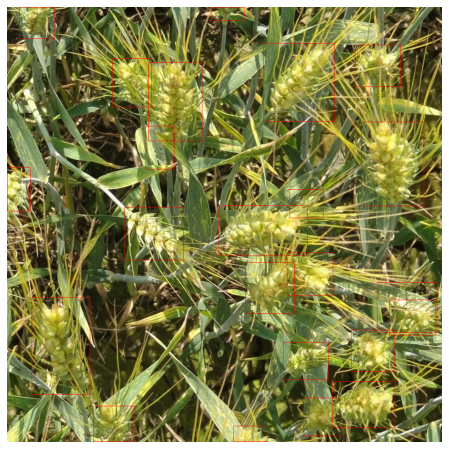

In [16]:
import matplotlib.pyplot as plt

for j, (images, image_ids) in enumerate(test_data_loader):
    break

predictions = make_tta_predictions(images)

i = 1
sample = images[i].permute(1,2,0).cpu().numpy()

boxes, scores, labels = run_wbf(predictions, image_index=i)
boxes = boxes.round().astype(np.int32).clip(min=0, max=1024)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 1)

ax.set_axis_off()
ax.imshow(sample);

In [17]:
test_df.to_csv('submission.csv', index=False)

In [18]:
cat submission.csv

image_id,PredictionString
aac893a91,0.9937 613 911 84 112 0.9851 59 1 122 166 0.9845 737 768 83 123 0.9803 241 84 142 154 0.9802 593 775 96 125 0.9795 22 451 112 158 0.9761 688 390 129 181 0.9745 354 528 101 92 0.9688 455 855 89 99 0.9679 811 689 116 222 0.9408 82 613 127 88 0.9242 173 563 118 200 0.9011 546 527 141 199 0.8971 554 72 145 191 0.8884 325 665 127 155 0.8249 60 852 126 79 0.7186 232 841 120 89 0.6841 316 865 83 95 0.6146 301 1 77 67 0.4908 479 987 81 36 0.3648 357 266 122 159 0.3263 823 920 124 102 0.2718 382 327 90 94 0.2377 233 830 172 134 0.1438 113 587 152 155 0.1017 828 629 88 134
51f1be19e,0.9851 498 467 209 118 0.9701 277 471 138 124 0.9671 810 760 101 98 0.9665 650 789 107 88 0.9640 834 270 147 198 0.9459 765 881 148 109 0.9423 603 85 168 184 0.9380 203 939 98 84 0.9363 819 89 107 98 0.9255 333 130 126 185 0.9092 248 121 92 114 0.9059 561 601 115 120 0.9008 0 377 55 103 0.8845 697 920 86 89 0.8356 29 0 83 74 0.8243 659 578 108 101 0.6500 58 683 137 229 0.4487 900 6